###Autoregressive Token Generation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from IPython.display import display, Markdown

# Ensure model and tokenizer are loaded (from Step 1)
if 'model' not in locals():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    model = AutoModelForCausalLM.from_pretrained("gpt2")

C:\Users\marci\anaconda3\envs\DATAENLIGHT_AI_LAB\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# The Autoregressive Loop: Generating text token-by-token
input_text = "The secret to writing code is"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

print(f"Starting Text: '{input_text}'\n" + "-"*40)

# We will generate 5 new tokens, one at a time
for i in range(20):
    with torch.no_grad():
        # 1. Forward pass: Get logits for the last token
        outputs = model(input_ids)
        next_token_logits = outputs.logits[:, -1, :]

        # 2. Convert logits to probabilities (Greedy approach here)
        probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
        next_token_id = torch.argmax(probs, dim=-1).unsqueeze(0)
        next_token = torch.argmax(probs, dim=-1).item()

        # 3. Decode the new token to see what it is
        next_token_str = tokenizer.decode([next_token])

        # 4. Append the new token to the history (Autoregression)
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

        print(f"Step {i+1}: Generated token '{next_token_str}'")

print("-" * 40)
print(f"Final Sequence: '{tokenizer.decode(input_ids[0])}'")

Starting Text: 'The secret to writing code is'
----------------------------------------
Step 1: Generated token ' to'
Step 2: Generated token ' write'
Step 3: Generated token ' it'
Step 4: Generated token ' in'
Step 5: Generated token ' a'
Step 6: Generated token ' way'
Step 7: Generated token ' that'
Step 8: Generated token ' makes'
Step 9: Generated token ' it'
Step 10: Generated token ' easy'
Step 11: Generated token ' to'
Step 12: Generated token ' understand'
Step 13: Generated token '.'
Step 14: Generated token '
'
Step 15: Generated token '
'
Step 16: Generated token 'The'
Step 17: Generated token ' first'
Step 18: Generated token ' thing'
Step 19: Generated token ' you'
Step 20: Generated token ' need'
----------------------------------------
Final Sequence: 'The secret to writing code is to write it in a way that makes it easy to understand.

The first thing you need'


LOW TEMPERATURE (0.1): The model is 'Conservative' and 'Sure'


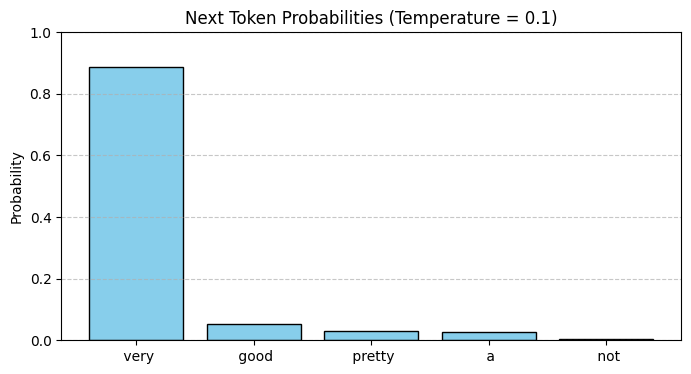


STANDARD TEMPERATURE (1.0): The model is 'Natural'


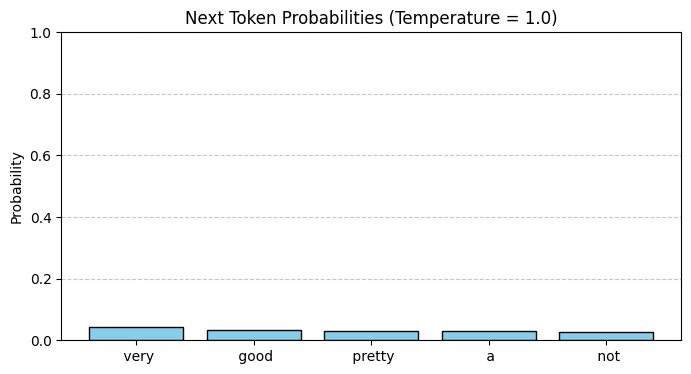


HIGH TEMPERATURE (2.0): The model is 'Creative' or 'Hallucinating'


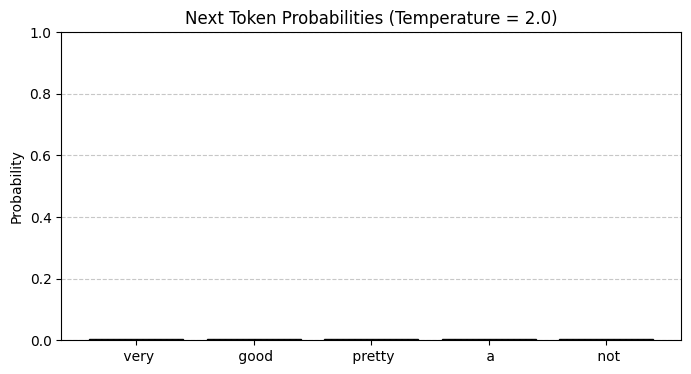

In [4]:
def plot_temperature_impact(text, temperature):
    """
    Visualizes how temperature affects the probability distribution of the next token.
    """
    inputs = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        # Get raw logits (scores)
        logits = model(**inputs).logits[:, -1, :]

    # Apply Temperature Scaling
    # Logits / Temperature
    scaled_logits = logits / temperature

    # Convert to probabilities
    probabilities = torch.nn.functional.softmax(scaled_logits, dim=-1)[0]

    # Get top 5 tokens for plotting
    top_probs, top_indices = torch.topk(probabilities, 5)
    top_tokens = [tokenizer.decode(idx) for idx in top_indices]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(top_tokens, top_probs.numpy(), color='skyblue', edgecolor='black')
    plt.title(f"Next Token Probabilities (Temperature = {temperature})")
    plt.ylabel("Probability")
    plt.ylim(0, 1.0) # Fixed scale for comparison
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- DEMONSTRATION ---
prompt = "The weather today is"

# 1. Low Temperature (0.1): Highly confident, deterministic (Peaky distribution)
print("LOW TEMPERATURE (0.1): The model is 'Conservative' and 'Sure'")
plot_temperature_impact(prompt, temperature=0.1)

# 2. Standard Temperature (1.0): Balanced (Normal distribution)
print("\nSTANDARD TEMPERATURE (1.0): The model is 'Natural'")
plot_temperature_impact(prompt, temperature=1.0)

# 3. High Temperature (2.0): Flattened, random (Uniform-like distribution)
print("\nHIGH TEMPERATURE (2.0): The model is 'Creative' or 'Hallucinating'")
plot_temperature_impact(prompt, temperature=2.0)

###DeepSeek Model Capability Comparison

In [5]:
# @title 🛠️ Step 1: Install Dependencies
# We need the latest transformers and bitsandbytes for 4-bit loading
#!pip install -q transformers accelerate bitsandbytes datasets sentencepiece

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import gc

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- CONFIGURATION ---
# The three stages of DeepSeek Math models
MODELS = {
    "1. Base Model (Pre-trained)": "deepseek-ai/deepseek-math-7b-base",
    "2. Instruct (SFT)": "deepseek-ai/deepseek-math-7b-instruct",
    "3. RL (Reasoning - RLHF)": "deepseek-ai/deepseek-math-7b-rl"
}

# --- HELPER FUNCTION: LOAD, RUN, UNLOAD ---
def run_deepseek_inference(model_name, model_id, prompt):
    print(f"\n{'='*60}\n🤖 LOADING: {model_name}\nID: {model_id}\n{'='*60}")

    # 1. Configure 4-bit Quantization (Crucial for Colab memory)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )

    # 2. Load Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

    # 3. Load Model
    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    # 4. Prepare Input
    # Base models just continue text. Instruct/RL models expect a specific format.
    # For DeepSeek Math, Instruct/RL generally use the "User: ... Assistant: ..." format
    # or specific chat templates. We'll use a generic formatting strategy.

    if "base" in model_id:
        # Base model: We frame it as a math problem completion
        input_text = f"Problem: {prompt}\nSolution:"
    else:
        # Instruct/RL: We use the apply_chat_template if available, or manual formatting
        # DeepSeek Math template: "User: {prompt}\n\nAssistant:"
        messages = [{"role": "user", "content": prompt}]
        input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # 5. Generate
    print("⏳ Thinking...")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,  # Allow space for Chain-of-Thought
            temperature=0.6,     # Slight randomness for creativity/reasoning
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # 6. Decode output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Clean up response for display (remove the prompt part if possible)
    # This is a simple visual cleanup
    response_clean = response.replace(input_text, "").strip()

    print(f"\n📝 RESPONSE:\n{'-'*20}\n{response_clean}\n{'-'*20}")

    # 7. AGGRESSIVE MEMORY CLEANUP
    # This is required to load the next model on free Colab
    del model
    del tokenizer
    del inputs
    del outputs
    torch.cuda.empty_cache()
    gc.collect()
    print("🧹 Memory cleared for next model.")

# --- STEP 2: LOAD DATA & RUN ---

# Load a hard math problem from GSM8K (Grade School Math 8k) dataset
print("\n📚 Loading GSM8K Dataset...")
dataset = load_dataset("gsm8k", "main", split="test")

problem = dataset[5]['question']

print(f"\n❓ PROBLEM TO SOLVE:\n{problem}")

# Iterate through the 3 models
for name, model_id in MODELS.items():
    run_deepseek_inference(name, model_id, problem)

print("\n✅ DEMONSTRATION COMPLETE")

Using device: cuda

📚 Loading GSM8K Dataset...

❓ PROBLEM TO SOLVE:
Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?

🤖 LOADING: 1. Base Model (Pre-trained)
ID: deepseek-ai/deepseek-math-7b-base


Loading checkpoint shards: 100%|██████████| 2/2 [00:28<00:00, 14.09s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
This problem can be solved by making a table and adding up the prices. The table below shows that Kylar needs to pay $62.40 for the 16 glasses.

This problem can be solved by making a table and adding up the prices. The table below shows that Kylar needs to pay $62.40 for the 16 glasses.

## 5.51: Multiply and Divide Fractions
Problem: Kylar wants to buy 16 glasses. One glass costs $5. Every second glass costs only 60% of the price. How much does Kylar need to pay for the glasses?
Solution:
This problem can be solved by making a table and adding up the prices. The table below shows that Kylar needs to pay $62.40 for the 16 glasses.
Problem: Kylar wants to buy 16 glasses. One glass costs $5. Every second glass costs only 60% of the price. How much does Kylar need to pay for the glasses?
Solution:
This problem can be solved by making a table and adding up the prices. The table below shows that Kylar needs to pay $62.40 for the 16 glasses.



Loading checkpoint shards: 100%|██████████| 2/2 [00:29<00:00, 14.66s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
User: Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?

Assistant: Let's break down the problem:

Kylar wants to buy 16 glasses. The first glass costs $5, and every second glass costs 60% of the price. 

So, we need to find out how many glasses cost full price and how many cost half price.

We can divide the glasses into two groups: the first 8 glasses and the last 8 glasses. 

The first 8 glasses cost full price, which is $5 each. So the total cost for these glasses is 8 * $5 = $40.

The last 8 glasses cost half price, which is 60% of $5. So each of these glasses costs $5 * 0.60 = $3.

So the total cost for these glasses is 8 * $3 = $24.

Adding the cost of the first 8 glasses and the last 8 glasses, we get $40 + $24 = $64.

So, Kylar needs to pay $64 for the 16 glasses.
--------------

Loading checkpoint shards: 100%|██████████| 2/2 [00:27<00:00, 13.66s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
User: Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?

Assistant: Kylar wants to buy 16 glasses. The first 8 glasses cost $5 each, so the cost for the first 8 glasses is 8 * $5 = $40.
The next 8 glasses cost only 60% of $5, so they cost 0.60 * $5 = $3 each. The cost for the next 8 glasses is 8 * $3 = $24.
To find the total cost, we add the cost of the first 8 glasses and the next 8 glasses: $40 + $24 = $64.
Kylar needs to pay $64 for the 16 glasses.
The answer is $\boxed{64}$.
--------------------
🧹 Memory cleared for next model.

✅ DEMONSTRATION COMPLETE


In [8]:
dataset[88]['question']

"Marilyn's first record sold 10 times as many copies as Harald's. If they sold 88,000 copies combined, how many copies did Harald sell?"

In [7]:
problem = dataset[88]['question']

print(f"\n❓ PROBLEM TO SOLVE:\n{problem}")

# Iterate through the 3 models
for name, model_id in MODELS.items():
    run_deepseek_inference(name, model_id, problem)

print("\n✅ DEMONSTRATION COMPLETE")


❓ PROBLEM TO SOLVE:
Marilyn's first record sold 10 times as many copies as Harald's. If they sold 88,000 copies combined, how many copies did Harald sell?

🤖 LOADING: 1. Base Model (Pre-trained)
ID: deepseek-ai/deepseek-math-7b-base


Loading checkpoint shards: 100%|██████████| 2/2 [00:28<00:00, 14.13s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
Let x = the number of copies that Harald sold.
Let 10x = the number of copies that Marilyn sold.
10x + x = 88,000
11x = 88,000
11x/11 = 88,000/11
x = 8,000
Harald sold 8,000 copies.
Problem: The sum of two numbers is 100. The first number is 20 less than the second. What are the numbers?
Solution:
Let x = the first number.
Let x + 20 = the second number.
x + (x + 20) = 100
2x + 20 = 100
2x + 20 - 20 = 100 - 20
2x = 80
2x/2 = 80/2
x = 40
The first number is 40. The second number is 20 more than the first:
40 + 20 = 60
The second number is 60.
Problem: The sum of two numbers is 100. The first number is 20 less than the second. What are the numbers?
Solution:
Let x = the first number.
Let x + 20 = the second number.
x + (x + 20) = 100
2x + 20 = 100
2x + 20 - 20 = 100 - 20
2x = 80
2x/2 = 80/2
x = 40
The first number is 40. The second number is 20 more than the first:
40 + 20 = 60
The second number is 60.
Problem: The sum of three consecutive 

Loading checkpoint shards: 100%|██████████| 2/2 [00:26<00:00, 13.36s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
User: Marilyn's first record sold 10 times as many copies as Harald's. If they sold 88,000 copies combined, how many copies did Harald sell?

Assistant: Let's assume Harald sold x copies.
Marilyn sold 10 times as many copies as Harald, so Marilyn sold 10x copies.
The total number of copies sold is x + 10x = 88,000.
Combining like terms, we get 11x = 88,000.
Dividing both sides by 11, we get x = 8,000.
Therefore, Harald sold 8,000 copies.
The answer is $\boxed{8000}$.
--------------------
🧹 Memory cleared for next model.

🤖 LOADING: 3. RL (Reasoning - RLHF)
ID: deepseek-ai/deepseek-math-7b-rl


Loading checkpoint shards: 100%|██████████| 2/2 [00:28<00:00, 14.37s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
User: Marilyn's first record sold 10 times as many copies as Harald's. If they sold 88,000 copies combined, how many copies did Harald sell?

Assistant: Let's say the number of copies Harald sold is $x$. Then, the number of copies Marilyn sold is $10x$. The total number of copies sold is the sum of the copies sold by Harald and Marilyn, which is $x + 10x = 88000$.

Combining like terms, we have $11x = 88000$.

To find the value of $x$, we divide both sides of the equation by 11: $x = \frac{88000}{11} = 8000$.

So, Harald sold 8000 copies. The answer is $\boxed{8000}$.
--------------------
🧹 Memory cleared for next model.

✅ DEMONSTRATION COMPLETE


In [9]:
problem = dataset[978]['question']

print(f"\n❓ PROBLEM TO SOLVE:\n{problem}")

# Iterate through the 3 models
for name, model_id in MODELS.items():
    run_deepseek_inference(name, model_id, problem)

print("\n✅ DEMONSTRATION COMPLETE")


❓ PROBLEM TO SOLVE:
The red car is 40% cheaper than the blue car. The price of the blue car is $100. How much do both cars cost?

🤖 LOADING: 1. Base Model (Pre-trained)
ID: deepseek-ai/deepseek-math-7b-base


Loading checkpoint shards: 100%|██████████| 2/2 [00:30<00:00, 15.02s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
The red car costs $60 and the blue car costs $100.
If you are familiar with the "percent" concept and you know that 40% is 40/100 = 2/5, then you can find the price of the red car by solving the equation:
100 - 40% of 100 = x
100 - 2/5*100 = x
100 - 40 = x
x = 60
If you are not familiar with the "percent" concept, then here is one way to solve this problem:
The red car costs 40% less than the blue car. This means that 40% of the price of the blue car is subtracted from the price of the blue car to obtain the price of the red car.
40% of the price of the blue car is 40/100 * 100 = 40.
So, the price of the red car is 100 - 40 = 60.
--------------------
🧹 Memory cleared for next model.

🤖 LOADING: 2. Instruct (SFT)
ID: deepseek-ai/deepseek-math-7b-instruct


Loading checkpoint shards: 100%|██████████| 2/2 [00:27<00:00, 13.75s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
User: The red car is 40% cheaper than the blue car. The price of the blue car is $100. How much do both cars cost?

Assistant: If the blue car costs $100, then the red car costs 40% less than the blue car, which is $100 * 40% = $40 less.
So the red car costs $100 - $40 = $60.
Therefore, both cars cost $100 + $60 = $160.
The answer is $\boxed{160}$.
--------------------
🧹 Memory cleared for next model.

🤖 LOADING: 3. RL (Reasoning - RLHF)
ID: deepseek-ai/deepseek-math-7b-rl


Loading checkpoint shards: 100%|██████████| 2/2 [00:32<00:00, 16.34s/it]


⏳ Thinking...

📝 RESPONSE:
--------------------
User: The red car is 40% cheaper than the blue car. The price of the blue car is $100. How much do both cars cost?

Assistant: If the blue car costs $100, then the red car is 40% cheaper than the blue car. To find the price of the red car, we need to subtract 40% of the blue car's price from the blue car's price.

40% of $100 is (40/100) * $100 = $40.

So, the price of the red car is $100 - $40 = $60.

To find the total cost of both cars, we add the prices of the blue car and the red car: $100 + $60 = $160.

So, both cars cost $160.
The answer is $\boxed{160}$.
--------------------
🧹 Memory cleared for next model.

✅ DEMONSTRATION COMPLETE
